In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas
import geopy
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

In [2]:
data = pd.read_csv('data/all_features_df.csv', index_col = 'Unnamed: 0')

In [3]:
data.head()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology
0,221900.0,1180,7,47.5112,-122.257,2.038307,0.261867,4.950174,12.705036
1,538000.0,2570,7,47.7210,-122.319,5.052058,0.682377,14.813168,10.800338
2,180000.0,770,6,47.7379,-122.233,1.337990,2.003000,13.499367,10.838220
3,604000.0,1960,7,47.5208,-122.393,2.448557,1.729431,14.476522,11.547177
4,510000.0,1680,8,47.6168,-122.045,2.672832,1.179255,8.548014,21.182016


C:\Users\danar\anaconda3\envs\geo\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 0.5485291707194189
Kurtosis: -0.5652634777803058


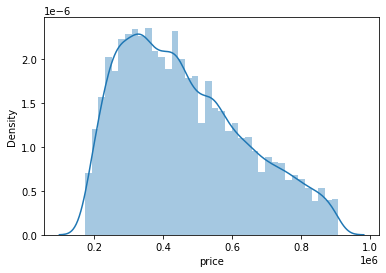

In [4]:
sns.distplot(data['price'])
print("Skewness:", data['price'].skew())
print("Kurtosis:", data['price'].kurt())

In [5]:
x_cols = ['sqft_living','grade','min_dist_park',
       'closest_distance_to_top_school', 'closest_distance_to_great_coffee',
       'closest_distance_to_scientology']
y = ['price']

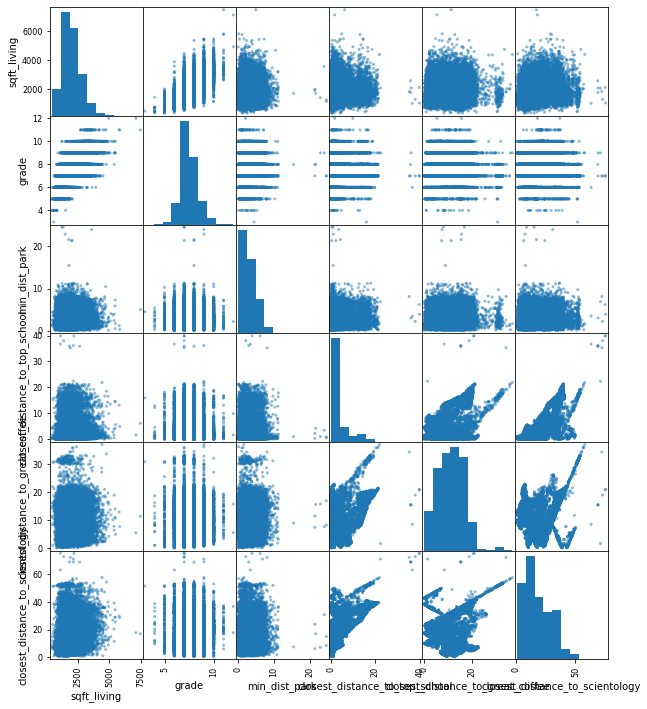

In [6]:
pd.plotting.scatter_matrix(data[x_cols], figsize=(10,12));

### Investigate distribution, skew, kurtosis before filtering price

In [7]:
for col in x_cols: 
    print('Skew: ' + col, data[col].skew())
    print('Kurtosis: ' + col, data[col].kurt())
    print(" ")

Skew: sqft_living 0.7681843591935618
Kurtosis: sqft_living 0.8219482843887103
 
Skew: grade 0.475803073181307
Kurtosis: grade 0.6679381364625612
 
Skew: min_dist_park 1.205427367383708
Kurtosis: min_dist_park 3.9928978255283707
 
Skew: closest_distance_to_top_school 2.07081534646944
Kurtosis: closest_distance_to_top_school 4.115792045291801
 
Skew: closest_distance_to_great_coffee 0.38716982689043905
Kurtosis: closest_distance_to_great_coffee 0.46445665273522074
 
Skew: closest_distance_to_scientology 0.729624297126709
Kurtosis: closest_distance_to_scientology -0.13070775209001573
 


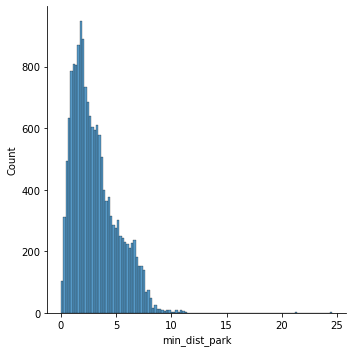

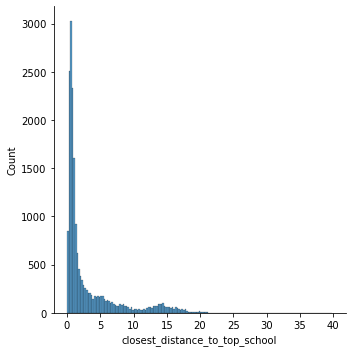

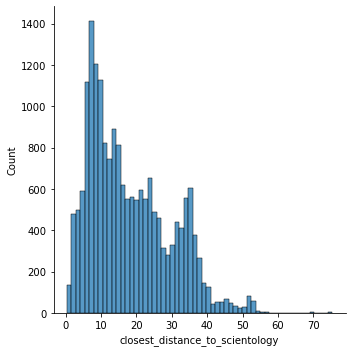

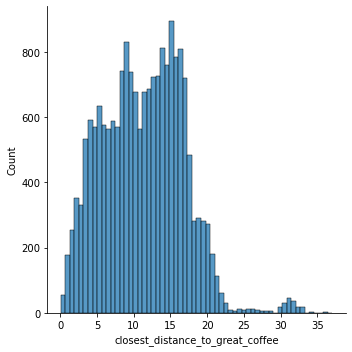

In [8]:
sns.displot(data['min_dist_park']);
sns.displot(data['closest_distance_to_top_school']);
sns.displot(data['closest_distance_to_scientology']);
sns.displot(data['closest_distance_to_great_coffee']);

### Take care of outliers & filter price

#### Start with outliers

Starting with distance to parks

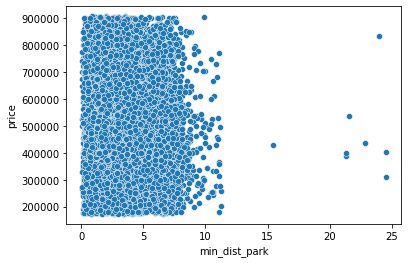

In [10]:
#quick outlier check 
sns.scatterplot(data = data, x = 'min_dist_park', y = 'price');

Ha. Let's take care of those obvious outliers right away 

In [11]:
park_outliers = data['min_dist_park']<15
filtered_park = data[park_outliers]

Moving on to distance from a top school

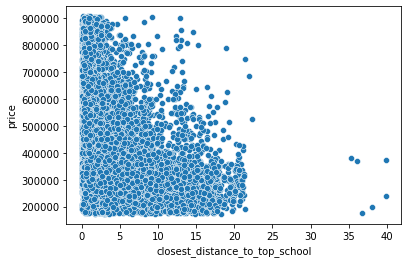

In [12]:
sns.scatterplot(data = filtered_park, x = 'closest_distance_to_top_school', y = 'price');

In [13]:
school_outliers = filtered_park['closest_distance_to_top_school']<35
filtered_park_school = filtered_park[school_outliers]

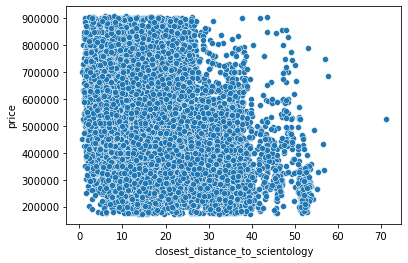

In [14]:
sns.scatterplot(data = filtered_park_school, x = 'closest_distance_to_scientology', y = 'price');

In [15]:
sci_outliers = filtered_park_school['closest_distance_to_scientology'] < 70
filtered_park_school_sci = filtered_park_school[sci_outliers]

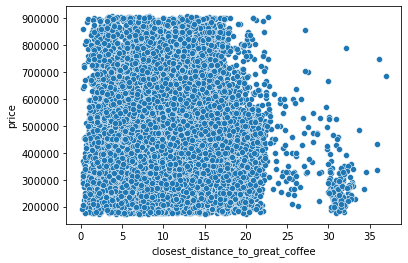

In [16]:
sns.scatterplot(data = filtered_park_school_sci, x = 'closest_distance_to_great_coffee', y = 'price');

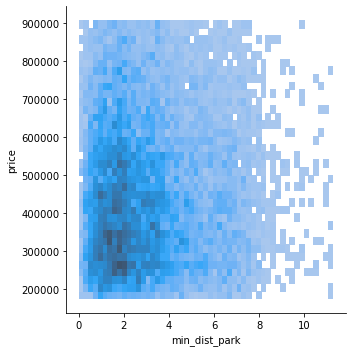

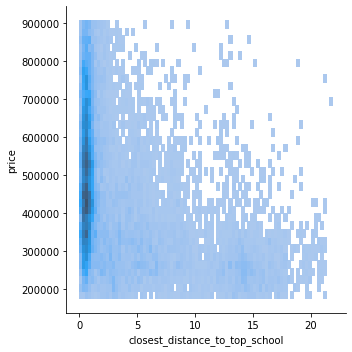

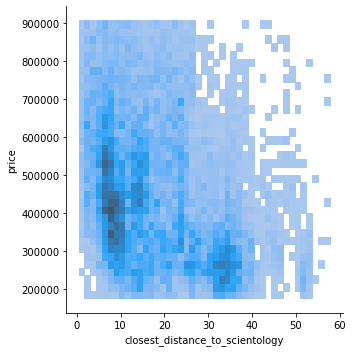

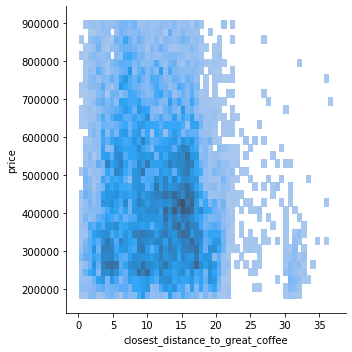

In [17]:
sns.displot(x = filtered_park_school_sci['min_dist_park'], y = filtered_park_school_sci['price']);
sns.displot(x = filtered_park_school_sci['closest_distance_to_top_school'], y = filtered_park_school_sci['price']);
sns.displot(x = filtered_park_school_sci['closest_distance_to_scientology'], y = filtered_park_school_sci['price']);
sns.displot(x = filtered_park_school_sci['closest_distance_to_great_coffee'], y = filtered_park_school_sci['price']);

Quick look tells me that densest areas are (very generally): 
1. park distance: below 4km and under 600k
2. school distance: approx. 0 - 2km and between 300k - 800k
3. scientology distance: 5 - 15km:300-600k with another bump around 30-35km: 250-350k
4. coffee distance: below 20km and under 600k

#### Based on some basic info and the findings above, going to decide how to filter for price

In [18]:
data2 = filtered_park_school_sci

In [19]:
print('mean: ' + str(data2.price.mean()))
print('mode: ' + str(data2.price.mode()))
print('median: ' + str(data2.price.median()))

mean: 457795.2580410244
mode: 0    350000.0
dtype: float64
median: 429950.0


In [20]:
stats.mode(data2['price'])

ModeResult(mode=array([350000.]), count=array([156]))

Mode of 350k and median of 430k, let's try filtering by price around 300k - 450k

### Filter price 300k > 450k

In [21]:
filtered_price = data2['price'].between(300000,450000)
filtered_data = data2[filtered_price]
filtered_data.head()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology
9,323000.0,1890,7,47.3684,-122.031,5.146491,0.847291,16.300571,35.338388
12,310000.0,1430,7,47.7558,-122.229,2.499865,3.981486,15.379887,9.470254
13,400000.0,1370,7,47.6127,-122.045,6.908752,1.163833,8.092579,21.183588
16,395000.0,1890,7,47.7277,-121.962,3.082875,5.897000,20.852798,28.260294
20,385000.0,1620,7,47.7025,-122.341,2.822163,0.287884,14.561551,9.034227


In [22]:
#sns.displot(x = filtered_data['min_dist_park'], y = filtered_data['price']);
#sns.displot(x = filtered_data['closest_distance_to_top_school'], y = filtered_data['price']);
#sns.displot(x = filtered_data['closest_distance_to_scientology'], y = filtered_data['price']);
#sns.displot(x = filtered_data['closest_distance_to_great_coffee'], y = filtered_data['price']);

Text(0.5, 1.0, 'Distribution of Filtered Price ($300-450k)')

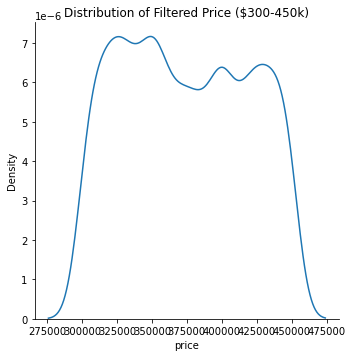

In [23]:
#look at new price distribution 
sns.displot(data = filtered_data['price'], kind = 'kde');
plt.title('Distribution of Filtered Price ($300-450k)')

In [26]:
for col in x_cols: 
    print(col)
    print('Skew: ', filtered_data[col].skew())
    print('Kurtosis: ', filtered_data[col].kurt())
    print('Correlation with price: ', filtered_data['price'].corr(filtered_data[col]))
    print(" ")

sqft_living
Skew:  0.5167739362009266
Kurtosis:  0.1356785282079418
Correlation with price:  0.07201113606259843
 
grade
Skew:  0.13369258429651643
Kurtosis:  1.0072396343327434
Correlation with price:  0.11333071343591822
 
min_dist_park
Skew:  0.8538184573877281
Kurtosis:  0.14395388415671473
Correlation with price:  0.010276506219266837
 
closest_distance_to_top_school
Skew:  2.0767403676590446
Kurtosis:  3.9989720105383184
Correlation with price:  -0.25037836430080657
 
closest_distance_to_great_coffee
Skew:  0.17083413186865903
Kurtosis:  0.11932973077636344
Correlation with price:  0.012209963088780373
 
closest_distance_to_scientology
Skew:  0.78041126639492
Kurtosis:  -0.2562765249783201
Correlation with price:  -0.21312982755582
 


### Filter price 350k > 500k

In [28]:
filtered_price2 = data2['price'].between(350000,500000)
filtered_data2 = data2[filtered_price]
filtered_data2.head()

,price,sqft_living,grade,lat,long,min_dist_park,closest_distance_to_top_school,closest_distance_to_great_coffee,closest_distance_to_scientology
11,468000.0,1160,7,47.6900,-122.292,3.230678,0.598800,10.906520,8.748762
13,400000.0,1370,7,47.6127,-122.045,6.908752,1.163833,8.092579,21.183588
16,395000.0,1890,7,47.7277,-121.962,3.082875,5.897000,20.852798,28.260294
17,485000.0,1600,7,47.6648,-122.343,2.601886,0.579095,12.498186,4.906281
20,385000.0,1620,7,47.7025,-122.341,2.822163,0.287884,14.561551,9.034227


Text(0.5, 1.0, 'Distribution of Filtered Price ($350-500k)')

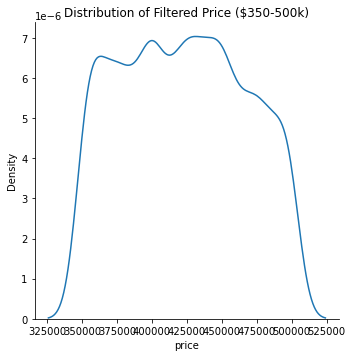

In [31]:
#look at new price distribution 
sns.displot(data = filtered_data2['price'], kind = 'kde');
plt.title('Distribution of Filtered Price ($350-500k)')

In [32]:
for col in x_cols: 
    print(col)
    print('Skew: ', filtered_data2[col].skew())
    print('Kurtosis: ', filtered_data2[col].kurt())
    print('Correlation with price: ', filtered_data2['price'].corr(filtered_data2[col]))
    print(" ")

sqft_living
Skew:  0.6702226986405865
Kurtosis:  0.5895480458227813
Correlation with price:  0.11784633000873491
 
grade
Skew:  0.31192044970553184
Kurtosis:  0.8421875734511204
Correlation with price:  0.1336558629159353
 
min_dist_park
Skew:  0.8621981039648575
Kurtosis:  0.19305295332812156
Correlation with price:  0.007266052202549152
 
closest_distance_to_top_school
Skew:  2.716421963856033
Kurtosis:  8.166864950702301
Correlation with price:  -0.14346778068795163
 
closest_distance_to_great_coffee
Skew:  0.04116386904939622
Kurtosis:  -0.05227723938476636
Correlation with price:  -0.02257313928651572
 
closest_distance_to_scientology
Skew:  1.0029762638710065
Kurtosis:  0.3134879644225621
Correlation with price:  -0.10053963563948501
 


In [39]:
f = 'price ~ sqft_living + grade + closest_distance_to_top_school + min_dist_park + closest_distance_to_great_coffee'
model = ols(formula = f, data = filtered_data2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     80.64
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.27e-81
Time:                        12:06:50   Log-Likelihood:                -60161.
No. Observations:                4982   AIC:                         1.203e+05
Df Residuals:                    4976   BIC:                         1.204e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         3.449e+05   6573.030     52.475      0.000    3.32e+05    3.58e+05
sqft_living                         11.5820      1.211      9.567      0.000       9.209      13.955
grade                             8233.0128    953.809      8.632      0.000    6363.126    1.01e+04
closest_distance_to_top_school   -3655.5721    215.307    -16.978      0.000   -4077.670   -3233.475
min_dist_park                      113.2296    305.750      0.370      0.711    -486.175     712.635
closest_distance_to_great_coffee   330.2969    119.309      2.768      0.006      96.399     564.195
==============================================================================
Omnibus:                      952.106   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.695
Skew:                           0.041   Prob(JB):                     3.20e-43
Kurtosis:                       2.033   Cond. No.                     2.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""